# Seq2Seq

## 1. 모델 소개

입력 sequnce로부터 다른 도메인의 sequence를 출력하는 모델 ( ex. 챗봇, 기계 번역 )

크게 두개의 아키텍쳐로 구성 : ENCODER & DECODER
- Encoder는 입력 데이터를 context vector로 압축
- Decoder는 context vector를 받아서 번역된 단어를 순차적으로 출력


Encoder & Decoder내부는 RNN / LSTM / GRU 등의 셀로 구성

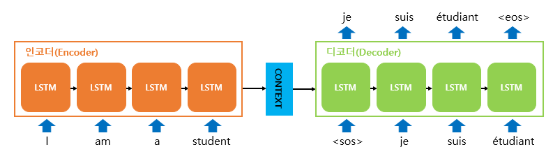

Embedding을 통해 text를 vector로 바꿔서 처리

### 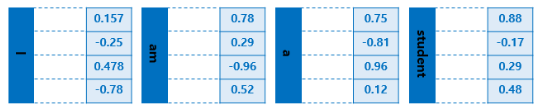

하나의 cell은 각각의 시점마다 2개의 입력을 받음
- 1) t-1 에서의 은닉 상태
- 2) t(현재) 에서의 입력 벡터

Decoder
- Decoder는 Encoder의 마지막 RNN 셀의 은닉 상태인 context vector를 첫번째 은닉 상태의 값으로 사용
- Decoder의 cell이 내는 output은 Dense layer를 거쳐 Softmax를 통해 단어들의 확률을 예측값으로 반환

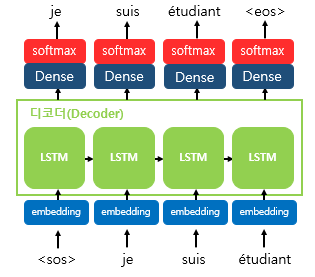

Teacher Forcing(교사 강요)
- Train 시, Decoder의 입력으로 이전 Decoder cell의 output이 아닌 실제값을 입력값으로 하는 방법!
- WHY? 만약 예측이 틀렸는데 이를 계속 다음 셀의 입력으로 사용 시, 전체적인 예측을 어렵게 할 수 있음

## 2. Character-Level NMT 구현

### seq2seq를 이용한 NMT 생성하기

## 1) Import Dataset

In [1]:
import pandas as pd
lines = pd.read_csv('fra.txt', names=['src','tar'], sep='\t')

In [2]:
len(lines)

170651

In [3]:
lines = lines.sample(30000)

In [4]:
lines.tail()

,src,tar
I have to do this alone.,Il me faut le faire seule.,CC-BY 2.0 (France) Attribution: tatoeba.org #1...
Tom went back to his own room and lay down.,Tom est retourné dans sa chambre et s'est allo...,CC-BY 2.0 (France) Attribution: tatoeba.org #4...
I go to the park.,Je vais au parc.,CC-BY 2.0 (France) Attribution: tatoeba.org #2...
Could you please call me back tomorrow?,"Pourriez-vous me rappeler demain, je vous prie ?",CC-BY 2.0 (France) Attribution: tatoeba.org #1...
I enjoyed swimming.,J'adorais nager.,CC-BY 2.0 (France) Attribution: tatoeba.org #2...


## 2) Data Preprocessing

번역 문장인 French에는 sos(start of sequence)와 eos(end of sequence) 넣어줘야!
- sos 대신 '\t',  eos 대신 '\n'를 넣어줌

In [5]:
lines.tar = lines.tar.apply(lambda x :'\t' + x +'\n')

글자 집합 생성 
- why not '단어'? : token 단위가 단어가 아닌 글자이므로

In [6]:
src_vocab = set()
for line in lines.src:
    for char in line:
        src_vocab.add(char)

tar_vocab = set()
for line in lines.tar:
    for char in line:
        tar_vocab.add(char)

In [7]:
src_vocab_size = len(src_vocab)+1
tar_vocab_size = len(tar_vocab)+1
print(src_vocab_size)
print(tar_vocab_size)

102
74


In [8]:
print(tar_vocab)

{'t', 'f', ' ', 'T', '#', 'V', 'Z', 'F', 'c', '&', 'b', '2', 'p', '.', 'O', 'w', 'N', 'C', '9', '8', ':', 'A', 'e', 'a', '_', 'v', 'U', 'D', 'x', '\n', 'Y', '7', ')', 'm', 'q', 'G', 'l', 'i', '4', 'z', 'K', 'k', '0', 'P', 'J', 'd', '-', 'o', 'u', 'W', 'I', 's', 'R', '5', 'j', '\t', 'y', 'B', 'Q', '3', 'M', 'r', 'E', '6', '(', 'n', 'h', 'S', 'g', 'H', 'X', '1', 'L'}


In [9]:
src_vocab = sorted(list(src_vocab))
tar_vocab = sorted(list(tar_vocab))

각 글자에 index 부여

In [10]:
src2index = dict([(word, i+1) for i, word in enumerate(src_vocab)])
tar2index = dict([(word, i+1) for i, word in enumerate(tar_vocab)])

In [11]:
print(src2index)

{' ': 1, '!': 2, '"': 3, '$': 4, '%': 5, "'": 6, ',': 7, '-': 8, '.': 9, '0': 10, '1': 11, '2': 12, '3': 13, '4': 14, '5': 15, '6': 16, '7': 17, '8': 18, '9': 19, ':': 20, ';': 21, '?': 22, 'A': 23, 'B': 24, 'C': 25, 'D': 26, 'E': 27, 'F': 28, 'G': 29, 'H': 30, 'I': 31, 'J': 32, 'K': 33, 'L': 34, 'M': 35, 'N': 36, 'O': 37, 'P': 38, 'Q': 39, 'R': 40, 'S': 41, 'T': 42, 'U': 43, 'V': 44, 'W': 45, 'X': 46, 'Y': 47, 'Z': 48, 'a': 49, 'b': 50, 'c': 51, 'd': 52, 'e': 53, 'f': 54, 'g': 55, 'h': 56, 'i': 57, 'j': 58, 'k': 59, 'l': 60, 'm': 61, 'n': 62, 'o': 63, 'p': 64, 'q': 65, 'r': 66, 's': 67, 't': 68, 'u': 69, 'v': 70, 'w': 71, 'x': 72, 'y': 73, 'z': 74, '\xa0': 75, '«': 76, '»': 77, 'À': 78, 'Â': 79, 'Ç': 80, 'É': 81, 'Ê': 82, 'Ô': 83, 'à': 84, 'á': 85, 'â': 86, 'ç': 87, 'è': 88, 'é': 89, 'ê': 90, 'ë': 91, 'î': 92, 'ï': 93, 'ô': 94, 'ù': 95, 'û': 96, 'œ': 97, '\u2009': 98, '\u200b': 99, '’': 100, '\u202f': 101}


정수 인코딩

In [12]:
encoder_input = []

for line in lines.src:
    temp_X = []
    for w in line: 
        temp_X.append(src2index[w])
    encoder_input.append(temp_X)

In [13]:
print(encoder_input[:3])

[[42, 63, 61, 1, 66, 63, 62, 54, 60, 53, 9], [38, 53, 62, 67, 53, 67, 8, 68, 69, 1, 65, 69, 53, 1, 58, 53, 1, 64, 63, 69, 66, 66, 49, 57, 67, 1, 64, 49, 66, 60, 53, 66, 1, 84, 1, 42, 63, 61, 75, 22], [28, 49, 57, 68, 8, 57, 60, 1, 49, 69, 67, 67, 57, 1, 51, 56, 49, 69, 52, 1, 51, 56, 49, 65, 69, 53, 1, 58, 63, 69, 66, 101, 22]]


In [14]:
decoder_input = []

for line in lines.tar:
    temp_X = []
    for w in line:
        temp_X.append(tar2index[w])
    decoder_input.append(temp_X)

In [15]:
print(decoder_input[:3])

[[1, 23, 23, 8, 22, 45, 3, 12, 9, 10, 3, 6, 26, 65, 48, 61, 50, 52, 7, 3, 21, 67, 67, 65, 56, 49, 68, 67, 56, 62, 61, 20, 3, 67, 48, 67, 62, 52, 49, 48, 9, 62, 65, 54, 3, 4, 12, 11, 11, 11, 11, 15, 13, 3, 6, 23, 31, 7, 3, 5, 3, 4, 15, 12, 16, 15, 14, 13, 18, 3, 6, 63, 56, 67, 56, 67, 61, 48, 67, 62, 59, 52, 7, 2], [1, 23, 23, 8, 22, 45, 3, 12, 9, 10, 3, 6, 26, 65, 48, 61, 50, 52, 7, 3, 21, 67, 67, 65, 56, 49, 68, 67, 56, 62, 61, 20, 3, 67, 48, 67, 62, 52, 49, 48, 9, 62, 65, 54, 3, 4, 13, 15, 12, 14, 13, 14, 15, 3, 6, 23, 31, 7, 3, 5, 3, 4, 15, 17, 18, 13, 12, 10, 18, 3, 6, 21, 56, 57, 56, 7, 2], [1, 23, 23, 8, 22, 45, 3, 12, 9, 10, 3, 6, 26, 65, 48, 61, 50, 52, 7, 3, 21, 67, 67, 65, 56, 49, 68, 67, 56, 62, 61, 20, 3, 67, 48, 67, 62, 52, 49, 48, 9, 62, 65, 54, 3, 4, 13, 12, 12, 14, 10, 11, 3, 6, 23, 31, 7, 3, 5, 3, 4, 18, 16, 19, 10, 14, 15, 3, 6, 66, 48, 50, 65, 52, 51, 50, 52, 59, 67, 56, 50, 7, 2]]


target word 앞에 붙어 있는 '\t' 제거 ( '\t'의 index인 1이 모든 문장 앞에서 제거됨 )

In [16]:
decoder_target = []

for line in lines.tar:
    t=0
    temp_X = []
    for w in line:
        if t>0:
            temp_X.append(tar2index[w])
        t=t+1     
    decoder_target.append(temp_X)

In [17]:
print(decoder_target[:3])

[[23, 23, 8, 22, 45, 3, 12, 9, 10, 3, 6, 26, 65, 48, 61, 50, 52, 7, 3, 21, 67, 67, 65, 56, 49, 68, 67, 56, 62, 61, 20, 3, 67, 48, 67, 62, 52, 49, 48, 9, 62, 65, 54, 3, 4, 12, 11, 11, 11, 11, 15, 13, 3, 6, 23, 31, 7, 3, 5, 3, 4, 15, 12, 16, 15, 14, 13, 18, 3, 6, 63, 56, 67, 56, 67, 61, 48, 67, 62, 59, 52, 7, 2], [23, 23, 8, 22, 45, 3, 12, 9, 10, 3, 6, 26, 65, 48, 61, 50, 52, 7, 3, 21, 67, 67, 65, 56, 49, 68, 67, 56, 62, 61, 20, 3, 67, 48, 67, 62, 52, 49, 48, 9, 62, 65, 54, 3, 4, 13, 15, 12, 14, 13, 14, 15, 3, 6, 23, 31, 7, 3, 5, 3, 4, 15, 17, 18, 13, 12, 10, 18, 3, 6, 21, 56, 57, 56, 7, 2], [23, 23, 8, 22, 45, 3, 12, 9, 10, 3, 6, 26, 65, 48, 61, 50, 52, 7, 3, 21, 67, 67, 65, 56, 49, 68, 67, 56, 62, 61, 20, 3, 67, 48, 67, 62, 52, 49, 48, 9, 62, 65, 54, 3, 4, 13, 12, 12, 14, 10, 11, 3, 6, 23, 31, 7, 3, 5, 3, 4, 18, 16, 19, 10, 14, 15, 3, 6, 66, 48, 50, 65, 52, 51, 50, 52, 59, 67, 56, 50, 7, 2]]


영어 & 프랑스어의 단어 길이 다름을 확인!
- Padding 시, 굳이 두 언어의 길이를 동일하게 해줄 필요 X 

In [18]:
max_src_len = max([len(line) for line in lines.src])
max_tar_len = max([len(line) for line in lines.tar])
print(max_src_len)
print(max_tar_len)

325
102


In [19]:
from tensorflow.keras.preprocessing.sequence import pad_sequences

encoder_input = pad_sequences(encoder_input, maxlen=max_src_len, padding='post')
decoder_input = pad_sequences(decoder_input, maxlen=max_tar_len, padding='post')
decoder_target = pad_sequences(decoder_target, maxlen=max_tar_len, padding='post')

One-Hot Encoding

In [20]:
from tensorflow.keras.utils import to_categorical

encoder_input = to_categorical(encoder_input)
decoder_input = to_categorical(decoder_input)
decoder_target = to_categorical(decoder_target)

## 3) Seq2Seq NMT 

In [ ]:
from tensorflow.keras.layers import Input, LSTM, Embedding, Dense
from tensorflow.keras.models import Model

### Encoder

In [21]:
encoder_inputs = Input(shape=(None, src_vocab_size))

encoder_lstm = LSTM(units=256, return_state=True)

encoder_outputs, state_h, state_c = encoder_lstm(encoder_inputs) 
encoder_states = [state_h, state_c] #encoder_output은 필요 없음 ( 나중에 Attention때는 필요 )

### Decoder

In [22]:
decoder_inputs = Input(shape=(None, tar_vocab_size))

decoder_lstm = LSTM(units=256, return_sequences=True, return_state=True)

decoder_outputs, _, _= decoder_lstm(decoder_inputs, initial_state=encoder_states)
decoder_softmax_layer = Dense(tar_vocab_size, activation='softmax')
decoder_outputs = decoder_softmax_layer(decoder_outputs)

In [23]:
model = Model([encoder_inputs, decoder_inputs], decoder_outputs)
model.compile(optimizer="adam", loss="categorical_crossentropy")

In [ ]:
model.fit(x=[encoder_input, decoder_input], 
          y=decoder_target, 
          batch_size=64, epochs=20, validation_split=0.2)

## 4) Seq2Seq 동작시키기
- 훈련 시 & 동작 시 다름! ( 교사 강요 )

동작 단계
- 1) 번역하고자 하는 입력 문장이 Encoder에 들어가 Hidden, Cell state 얻음
- 2) <SOS>에 해당하는 '\t'를 Decoder로 보냄
- 3) Decoder <EOS>에 해당하는 '\n'이 나올 때까지 다음 문자를 예측하는 행동을 반복

### Encoder

In [26]:
encoder_model = Model(inputs=encoder_inputs, outputs=encoder_states)

### Decoder

In [27]:
decoder_state_input_h = Input(shape=(256,))
decoder_state_input_c = Input(shape=(256,))

decoder_states_inputs = [decoder_state_input_h, decoder_state_input_c]

decoder_outputs, state_h, state_c = decoder_lstm(decoder_inputs, initial_state=decoder_states_inputs)
# 문장의 다음 단어를 예측하기 위해서 초기 상태를 이전 상태로 사용
decoder_states = [state_h, state_c]
decoder_outputs = decoder_softmax_layer(decoder_outputs)

In [28]:
decoder_model = Model(inputs=[decoder_inputs] + decoder_states_inputs, 
                      outputs=[decoder_outputs] + decoder_states)

index2src & index2tar

In [30]:
index2src = dict((i, char) for char, i in src2index.items())
index2tar = dict((i, char) for char, i in tar2index.items())

In [31]:
def decode_sequence(input_seq):
    # state of Encoder
    states_value = encoder_model.predict(input_seq)
    
    # <SOS> One-hot Encoding
    target_seq = np.zeros((1, 1, tar_vocab_size))
    target_seq[0, 0, tar_to_index['\t']] = 1.

    stop_condition = False
    decoded_sentence = ""
    
    while not stop_condition: 
        output_tokens, h, c = decoder_model.predict([target_seq] + states_value)
        sampled_token_index = np.argmax(output_tokens[0, -1, :])
        sampled_char = index_to_tar[sampled_token_index]
        decoded_sentence += sampled_char

        # <sos>에 도달하거나 최대 길이를 넘으면 중단.
        if (sampled_char == '\n' or
           len(decoded_sentence) > max_tar_len):
            stop_condition = True

        # 길이가 1인 타겟 시퀀스를 업데이트 합니다.
        target_seq = np.zeros((1, 1, tar_vocab_size))
        target_seq[0, 0, sampled_token_index] = 1.

        # 상태를 업데이트 합니다.
        states_value = [h, c]

    return decoded_sentence

In [ ]:
import numpy as np

for seq_index in [1,10,100,100]: # 입력 문장의 인덱스
    input_seq = encoder_input[seq_index: seq_index + 1]
    decoded_sentence = decode_sequence(input_seq)
    print(35 * "-")
    print('Input Sentence:', lines.src[seq_index])
    print('Actual Sentence:', lines.tar[seq_index][1:len(lines.tar[seq_index])-1]) # '\t'와 '\n'을 빼고 출력
    print('Predicted Sentence:', decoded_sentence[:len(decoded_sentence)-1]) # '\n'을 빼고 출력